# Supplementary: Calculating model efficacy parameters

Author: Katie Tiley (katherine.tiley@lshtm.ac.uk) <br>
Date: 25 Oct 22

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import bisect
import time

### 1. Set up model
Parameters:

In [2]:
# MOSQUITO
alphaO = 0.5  # rate that eggs hatch into larvae
alphaL = 0.18  # rate that larvae pupate
alphaP = 1  # rate that pupae eclose
phi = 500*(1/14)    # number eggs laid per mosquito per day
muO = 0.01    # daily death rate of eggs
muL = 0.1*alphaL    # daily death rate of larvae
muP = 0.1*alphaP     # pupae death rate
muM = 1/14     # adult mosquito death rate
muF = 1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA = 1   # determines the density at which mortality remains proportionate
BB = 0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI = 0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT = 0    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c = 0.5      # mating competitiveness of released wolbachia males
cv = 1   # coverage of adulticide
e = 1.2      # relative mortality of wolbachia adults compared to wild adults
RR = 1       # release ratio of wolbachia eggs to wild type eggs
RRsupp = 1      # release ratio of wolbachia eggs to wild type eggs for suppression techniques

Initial conditions:
(equilibrium values previously defined in Supp)

In [3]:
O0 = 15947.608023052446
OW0 = 0
rOW0 = 0
OS0 = 0
L0 = 40271.71074193975
LW0 = 0
rLW0 = 0
LS0 = 0
P0 = 32.67541200187585
PW0 = 0
rPW0 = 0
PS0 = 0
M0 = 228.72754035145144
MW0 = 0
MS0 = 0
F0 = 228.72754035145144
FW0 = 0

Wolbachia release function:

In [4]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return 0 #O0
    else:
        return 0

Suppression functions:

In [5]:
# IIT

def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [6]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [7]:
# Environmental management

start_em=193
stop_em=200
em_eff= 1 #0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [8]:
# Larvicides (e.g. guppies)

start_lv=193
stop_lv=200
lv_eff= 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [9]:
# Adulticide

h = start_wol

def ad(t):    
    eff = 0 #4.9
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return eff

Model:

In [10]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch):
    
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = y
    
    #MOSQUITOES
    
    allfemales = 1+F+FW
    allmales = 1+M+MW+(MS*c)
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = em(t) * phi * F_nothing * M_nothing/allmales - alphaO*O - lv(t)*muO*O # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = em(t) * phi * F_wol * (M+MW)/allmales - alphaO*OW - lv(t)*muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW
    dOSdt = phi * allfemales * (MS*c)/allmales - alphaO*OS - muO*OS
    
    #Larvae
    dLdt =  alphaO*O - alphaL*L - lv(t)*muL*L
    dLWdt = alphaO*OW - alphaL*LW - lv(t)*muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    dLSdt = switch*alphaO*OS - alphaL*LS - muL*LS
    
    #Pupae 
    dPdt =  alphaL*(L/(1+((AA*(L+LW+LS))**BB))) - alphaP*P - lv(t)*muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW+LS))**BB))) - alphaP*PW - lv(t)*muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    dPSdt = alphaL*(LS/(1+((AA*(L+LW+LS))**BB))) - alphaP*PS - muP*PS
        
    #Adult
    dMdt =  .5*alphaP*P - muM*M - ad(t)*M*cv
    dMWdt = IIT(t)*RRsupp + .5*alphaP*(PW+rPW) - muM*1.2*MW - ad(t)*MW*cv
    dMSdt = SIT(t)*RRsupp - muM*1.2*MS # + .5*alphaP*PS remove for 1gSLT
    
    dFdt =  .5*alphaP*P - muF*F - ad(t)*F*cv
    dFWdt = .5*alphaP*(PW+rPW) - muF*1.2*FW - ad(t)*FW*cv

    return dOdt, dOWdt, drOWdt, dOSdt, dLdt, dLWdt, drLWdt, dLSdt, dPdt, dPWdt, drPWdt, dPSdt, dMdt, dMWdt, dMSdt, dFdt, dFWdt

Model prerequisites:

In [11]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # initial condition vector

Run model:

In [12]:
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

Visual check all suppression and Wolbachia functions are switched off:
(should see horizontal lines)

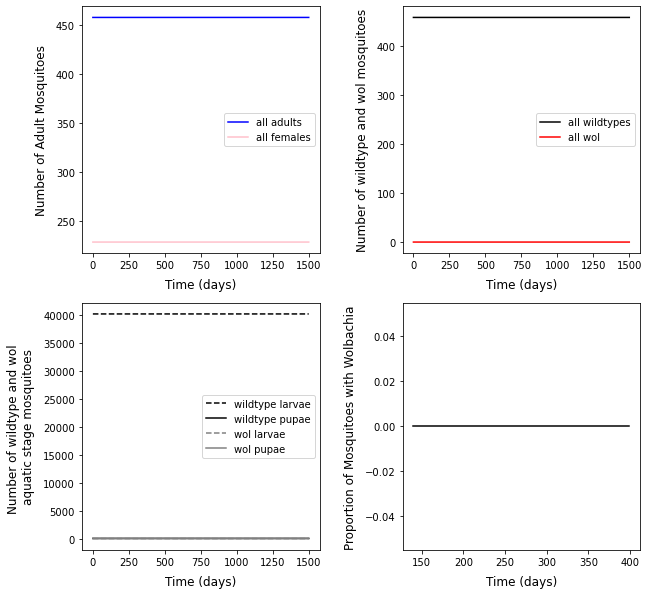

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes",fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes",fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes",fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia",fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

### 2. Calculating efficacy parameters

#### IIT:
(run for 5 weeks)

In [14]:
# switch on

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

In [15]:
# efficacy calculated as uninfected adult minimum population reached

start_time = time.time()

lower_bounds = [19.950,49.950,79.950]
upper_bounds = [20.049,50.049,80.049]

IIT_decrease = []
IIT_eff= []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for i in list(range(0,3)):

    for j in list(np.linspace(start,end,nums)):
        
        RRsupp = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate efficacy
        pop_min = min(M)+min(F)
        prop_decrease_min = (1-(pop_min/eq))*100
        
        # store results
        if lower_bounds[i] < prop_decrease_min < upper_bounds[i]:   
            IIT_decrease.append(prop_decrease_min)
            IIT_eff.append(round(j,3))
            break
    
    start = j
    nums = int(((end-start)*1000)+1)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 4.62 minutes


In [16]:
IIT_df = pd.DataFrame({'Target efficacy': [20,50,80]})
IIT_df['Achieved efficacy'] = IIT_decrease
IIT_df['RRsupp value'] = IIT_eff
IIT_df['Maximum delayed efficacy'] = ['NaN', 'NaN', 'NaN']

IIT_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20,19.979565,0.155,NaN
1,50,49.950855,0.640,NaN
2,80,79.952078,3.054,NaN


In [17]:
# efficacy calculated as uninfected adult population reached 5 weeks after the end of 5 week suppression period

lower_bounds = 59.950
upper_bounds = 60.049
five_week = start_wol+35

eq = 457.4550807029029
start = list(IIT_df.loc[IIT_df['Target efficacy'] == 50, 'RRsupp value'])
end = list(IIT_df.loc[IIT_df['Target efficacy'] == 80, 'RRsupp value'])
nums = int(round((end[0]-start[0])*1000)+1)

for j in list(np.linspace(start[0],end[0],nums)):
        
    RRsupp = j
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate efficacy
    pop_effect = M[five_week]+F[five_week]
    prop_decrease = (1-(pop_effect/eq))*100
    pop_min = min(M)+min(F)
    prop_decrease_min = (1-(pop_min/eq))*100
        
    # store results
    if lower_bounds < prop_decrease < upper_bounds:
        lit_eff = {'Target efficacy':60, 'Achieved efficacy':prop_decrease, 'RRsupp value':round(j,3), 'Maximum delayed efficacy':prop_decrease_min}
        break

In [18]:
IIT_df = IIT_df.append(lit_eff, ignore_index=True)

IIT_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20.0,19.979565,0.155,NaN
1,50.0,49.950855,0.640,NaN
2,80.0,79.952078,3.054,NaN
3,60.0,59.969591,1.152,63.276652


In [21]:
# efficacy calculated as uninfected adult population reached 10 weeks after the end of 5 week suppression period

start_time = time.time()

lower_bounds = 94.950
upper_bounds = 95.049
ten_week = start_wol+70

eq = 457.4550807029029
start = list(IIT_df.loc[IIT_df['Target efficacy'] == 80, 'RRsupp value'])
end = 50
nums = int(round((end-start[0])*1000)+1)

for j in list(np.linspace(start[0],end,nums)):
        
    RRsupp = j
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate efficacy
    pop_effect = M[ten_week]+F[ten_week]
    prop_decrease = (1-(pop_effect/eq))*100
    pop_min = min(M)+min(F)
    prop_decrease_min = (1-(pop_min/eq))*100
        
    # store results
    if lower_bounds < prop_decrease < upper_bounds:
        IIT_tenweek = {'Target efficacy':95, 'Achieved efficacy':prop_decrease, 'RRsupp value':round(j,3), 'Maximum delayed efficacy':prop_decrease_min}
        break
        
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

In [22]:
IIT_df = IIT_df.append(IIT_tenweek, ignore_index=True)

IIT_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20.0,19.979565,0.155,NaN
1,50.0,49.950855,0.640,NaN
2,80.0,79.952078,3.054,NaN
3,60.0,59.969591,1.152,63.276652
4,95.0,94.950023,42.486,95.498459


In [23]:
#save dataframe
IIT_df.to_csv('IIT_df.csv')

In [24]:
# switch off again

def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

#### SIT:
(run for 5 weeks)

In [74]:
# switch on

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0 
    else:
        return 0

In [76]:
# efficacy calculated as uninfected adult minimum population reached

start_time = time.time()

lower_bounds = [19.950,49.950,79.950]
upper_bounds = [20.049,50.049,80.049]
five_week = start_wol+35

SIT_decrease = []
SIT_eff = []
SIT_decrease_max = []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for i in list(range(0,3)):

    for j in list(np.linspace(start,end,nums)):
        
        RRsupp = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate efficacy
        pop_min = min(M)+min(F)
        prop_decrease_min = (1-(pop_min/eq))*100
        
        # store results
        if lower_bounds[i] < prop_decrease_min < upper_bounds[i]:   
            SIT_decrease.append(prop_decrease_min)
            SIT_eff.append(round(j,3))
            break     
    
    start = j
    nums = int(((end-start)*1000)+1)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 7.89 minutes


In [77]:
SIT_df = pd.DataFrame({'Target efficacy': [20,50,80]})
SIT_df['Achieved efficacy'] = SIT_decrease
SIT_df['RRsupp value'] = SIT_eff

SIT_df

,Target efficacy,Achieved efficacy,RRsupp value
0,20,19.997650,0.305
1,50,49.959542,1.236
2,80,79.951665,5.360


In [78]:
#save dataframe
SIT_df.to_csv('SIT_df.csv')

In [79]:
# switch off again

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

#### RIDL:
(run for 5 weeks)

In [21]:
# switch on

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

In [23]:
# efficacy calculated as uninfected adult minimum population reached

start_time = time.time()

lower_bounds = [19.950,49.950,79.950]
upper_bounds = [20.049,50.049,80.049]

RIDL_decrease = []
RIDL_eff= []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for i in list(range(0,3)):

    for j in list(np.linspace(start,end,nums)):
        
        RRsupp = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate efficacy
        pop_min = min(M)+min(F)
        prop_decrease_min = (1-(pop_min/eq))*100
        
        # store results
        
        
        if lower_bounds[i] < prop_decrease_min < upper_bounds[i]:   
            RIDL_decrease.append(prop_decrease_min)
            RIDL_eff.append(round(j,3))
#            print(lower_bounds[i], '<', prop_decrease_min, '<', upper_bounds[i])


            break
        
#        print('                                                           loop complete, RRsupp:',j)
    
    start = j
    nums = int(((end-start)*1000)+1)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

                                                           loop complete, RRsupp: 0.0
                                                           loop complete, RRsupp: 0.001
                                                           loop complete, RRsupp: 0.002
                                                           loop complete, RRsupp: 0.003
                                                           loop complete, RRsupp: 0.004
                                                           loop complete, RRsupp: 0.005
                                                           loop complete, RRsupp: 0.006
                                                           loop complete, RRsupp: 0.007
                                                           loop complete, RRsupp: 0.008
                                                           loop complete, RRsupp: 0.009000000000000001
                                                           loop complete, RRsupp: 0.01
                    

                                                           loop complete, RRsupp: 0.094
                                                           loop complete, RRsupp: 0.095
                                                           loop complete, RRsupp: 0.096
                                                           loop complete, RRsupp: 0.097
                                                           loop complete, RRsupp: 0.098
                                                           loop complete, RRsupp: 0.099
                                                           loop complete, RRsupp: 0.1
                                                           loop complete, RRsupp: 0.101
                                                           loop complete, RRsupp: 0.10200000000000001
                                                           loop complete, RRsupp: 0.10300000000000001
                                                           loop complete, RRsupp: 0.1040000000

                                                           loop complete, RRsupp: 0.183
                                                           loop complete, RRsupp: 0.184
                                                           loop complete, RRsupp: 0.185
                                                           loop complete, RRsupp: 0.186
                                                           loop complete, RRsupp: 0.187
                                                           loop complete, RRsupp: 0.188
                                                           loop complete, RRsupp: 0.189
                                                           loop complete, RRsupp: 0.19
                                                           loop complete, RRsupp: 0.191
                                                           loop complete, RRsupp: 0.192
                                                           loop complete, RRsupp: 0.193
                                 

                                                           loop complete, RRsupp: 0.273
                                                           loop complete, RRsupp: 0.274
                                                           loop complete, RRsupp: 0.275
                                                           loop complete, RRsupp: 0.276
                                                           loop complete, RRsupp: 0.277
                                                           loop complete, RRsupp: 0.278
                                                           loop complete, RRsupp: 0.279
                                                           loop complete, RRsupp: 0.28
                                                           loop complete, RRsupp: 0.281
                                                           loop complete, RRsupp: 0.28200000000000003
                                                           loop complete, RRsupp: 0.28300000000000003
     

                                                           loop complete, RRsupp: 0.363
                                                           loop complete, RRsupp: 0.364
                                                           loop complete, RRsupp: 0.365
                                                           loop complete, RRsupp: 0.366
                                                           loop complete, RRsupp: 0.367
                                                           loop complete, RRsupp: 0.368
                                                           loop complete, RRsupp: 0.369
                                                           loop complete, RRsupp: 0.37
                                                           loop complete, RRsupp: 0.371
                                                           loop complete, RRsupp: 0.372
                                                           loop complete, RRsupp: 0.373
                                 

                                                           loop complete, RRsupp: 0.455
                                                           loop complete, RRsupp: 0.456
                                                           loop complete, RRsupp: 0.457
                                                           loop complete, RRsupp: 0.458
                                                           loop complete, RRsupp: 0.459
                                                           loop complete, RRsupp: 0.46
                                                           loop complete, RRsupp: 0.461
                                                           loop complete, RRsupp: 0.462
                                                           loop complete, RRsupp: 0.463
                                                           loop complete, RRsupp: 0.464
                                                           loop complete, RRsupp: 0.465
                                 

                                                           loop complete, RRsupp: 0.548
                                                           loop complete, RRsupp: 0.549
                                                           loop complete, RRsupp: 0.55
                                                           loop complete, RRsupp: 0.551
                                                           loop complete, RRsupp: 0.552
                                                           loop complete, RRsupp: 0.553
                                                           loop complete, RRsupp: 0.554
                                                           loop complete, RRsupp: 0.555
                                                           loop complete, RRsupp: 0.556
                                                           loop complete, RRsupp: 0.557
                                                           loop complete, RRsupp: 0.558
                                 

                                                           loop complete, RRsupp: 0.641
                                                           loop complete, RRsupp: 0.642
                                                           loop complete, RRsupp: 0.643
                                                           loop complete, RRsupp: 0.644
                                                           loop complete, RRsupp: 0.645
                                                           loop complete, RRsupp: 0.646
                                                           loop complete, RRsupp: 0.647
                                                           loop complete, RRsupp: 0.648
                                                           loop complete, RRsupp: 0.649
                                                           loop complete, RRsupp: 0.65
                                                           loop complete, RRsupp: 0.651
                                 

                                                           loop complete, RRsupp: 0.7310000000000001
                                                           loop complete, RRsupp: 0.732
                                                           loop complete, RRsupp: 0.7330000000000001
                                                           loop complete, RRsupp: 0.734
                                                           loop complete, RRsupp: 0.7350000000000001
                                                           loop complete, RRsupp: 0.736
                                                           loop complete, RRsupp: 0.7370000000000001
                                                           loop complete, RRsupp: 0.738
                                                           loop complete, RRsupp: 0.739
                                                           loop complete, RRsupp: 0.74
                                                           loop compl

                                                           loop complete, RRsupp: 0.8240000000000001
                                                           loop complete, RRsupp: 0.825
                                                           loop complete, RRsupp: 0.8260000000000001
                                                           loop complete, RRsupp: 0.827
                                                           loop complete, RRsupp: 0.8280000000000001
                                                           loop complete, RRsupp: 0.829
                                                           loop complete, RRsupp: 0.8300000000000001
                                                           loop complete, RRsupp: 0.831
                                                           loop complete, RRsupp: 0.8320000000000001
                                                           loop complete, RRsupp: 0.833
                                                       

                                                           loop complete, RRsupp: 0.914
                                                           loop complete, RRsupp: 0.915
                                                           loop complete, RRsupp: 0.916
                                                           loop complete, RRsupp: 0.917
                                                           loop complete, RRsupp: 0.918
                                                           loop complete, RRsupp: 0.919
                                                           loop complete, RRsupp: 0.92
                                                           loop complete, RRsupp: 0.921
                                                           loop complete, RRsupp: 0.922
                                                           loop complete, RRsupp: 0.923
                                                           loop complete, RRsupp: 0.924
                                 

                                                           loop complete, RRsupp: 1.004
                                                           loop complete, RRsupp: 1.0050000000000001
                                                           loop complete, RRsupp: 1.006
                                                           loop complete, RRsupp: 1.0070000000000001
                                                           loop complete, RRsupp: 1.008
                                                           loop complete, RRsupp: 1.0090000000000001
                                                           loop complete, RRsupp: 1.01
                                                           loop complete, RRsupp: 1.0110000000000001
                                                           loop complete, RRsupp: 1.012
                                                           loop complete, RRsupp: 1.0130000000000001
                                                        

                                                           loop complete, RRsupp: 1.097
                                                           loop complete, RRsupp: 1.098
                                                           loop complete, RRsupp: 1.099
                                                           loop complete, RRsupp: 1.1
                                                           loop complete, RRsupp: 1.101
                                                           loop complete, RRsupp: 1.102
                                                           loop complete, RRsupp: 1.103
                                                           loop complete, RRsupp: 1.104
                                                           loop complete, RRsupp: 1.105
                                                           loop complete, RRsupp: 1.106
                                                           loop complete, RRsupp: 1.107
                                  

                                                           loop complete, RRsupp: 1.19
                                                           loop complete, RRsupp: 1.191
                                                           loop complete, RRsupp: 1.192
                                                           loop complete, RRsupp: 1.193
                                                           loop complete, RRsupp: 1.194
                                                           loop complete, RRsupp: 1.195
                                                           loop complete, RRsupp: 1.196
                                                           loop complete, RRsupp: 1.197
                                                           loop complete, RRsupp: 1.198
                                                           loop complete, RRsupp: 1.199
                                                           loop complete, RRsupp: 1.2
                                   

In [24]:
RIDL_df = pd.DataFrame({'Target efficacy': [20,50,80]})
RIDL_df['Achieved efficacy'] = RIDL_decrease
RIDL_df['RRsupp value'] = RIDL_eff
RIDL_df['Maximum delayed efficacy'] = ['NaN', 'NaN', 'NaN']

RIDL_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20,19.984943,0.138,NaN
1,50,50.011705,0.450,NaN
2,80,79.968370,1.221,NaN


In [26]:
# efficacy calculated as uninfected adult population reached 10 weeks after the end of 5 week suppression period

start_time = time.time()

lower_bounds = 44.950
upper_bounds = 45.049
five_week = start_wol+35

eq = 457.4550807029029
start = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 20, 'RRsupp value'])
end = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 80, 'RRsupp value'])
nums = int(round((end[0]-start[0])*1000)+1)

for j in list(np.linspace(start[0],end[0],nums)):
        
    RRsupp = j
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate efficacy
    pop_effect = M[five_week]+F[five_week]
    prop_decrease = (1-(pop_effect/eq))*100
    pop_min = min(M)+min(F)
    prop_decrease_min = (1-(pop_min/eq))*100
        
    # store results
    if lower_bounds < prop_decrease < upper_bounds:
        lit_eff = {'Target efficacy':45, 'Achieved efficacy':prop_decrease, 'RRsupp value':round(j,3), 'Maximum delayed efficacy':prop_decrease_min}
#        print("ok")
        break
        
#    print(lower_bounds,'<', prop_decrease,'<', upper_bounds)
#    print('                                                           loop complete, RRsupp:',j)

44.95 < 15.313203476790893 < 45.049
                                                           loop complete, RRsupp: 0.138
44.95 < 15.417907340195992 < 45.049
                                                           loop complete, RRsupp: 0.139
44.95 < 15.522517073259777 < 45.049
                                                           loop complete, RRsupp: 0.14
44.95 < 15.627032570411526 < 45.049
                                                           loop complete, RRsupp: 0.14100000000000001
44.95 < 15.731451951513197 < 45.049
                                                           loop complete, RRsupp: 0.14200000000000002
44.95 < 15.835777297409749 < 45.049
                                                           loop complete, RRsupp: 0.14300000000000002
44.95 < 15.940007497669262 < 45.049
                                                           loop complete, RRsupp: 0.14400000000000002
44.95 < 16.044143315528736 < 45.049
                                         

44.95 < 22.01820115679728 < 45.049
                                                           loop complete, RRsupp: 0.20400000000000001
44.95 < 22.116546775704137 < 45.049
                                                           loop complete, RRsupp: 0.20500000000000002
44.95 < 22.2147962683911 < 45.049
                                                           loop complete, RRsupp: 0.20600000000000002
44.95 < 22.312946499286312 < 45.049
                                                           loop complete, RRsupp: 0.20700000000000002
44.95 < 22.41099877471415 < 45.049
                                                           loop complete, RRsupp: 0.20800000000000002
44.95 < 22.508953095237526 < 45.049
                                                           loop complete, RRsupp: 0.20900000000000002
44.95 < 22.606811024100658 < 45.049
                                                           loop complete, RRsupp: 0.21000000000000002
44.95 < 22.70456945657402 < 45.049
   

44.95 < 28.022208299535944 < 45.049
                                                           loop complete, RRsupp: 0.267
44.95 < 28.114357667291266 < 45.049
                                                           loop complete, RRsupp: 0.268
44.95 < 28.206407766800435 < 45.049
                                                           loop complete, RRsupp: 0.269
44.95 < 28.29836022029635 < 45.049
                                                           loop complete, RRsupp: 0.27
44.95 < 28.39021360694702 < 45.049
                                                           loop complete, RRsupp: 0.271
44.95 < 28.48196973988808 < 45.049
                                                           loop complete, RRsupp: 0.272
44.95 < 28.573624795653785 < 45.049
                                                           loop complete, RRsupp: 0.273
44.95 < 28.665181294099174 < 45.049
                                                           loop complete, RRsupp: 0.274
44.95 < 28.7

44.95 < 33.80697871507831 < 45.049
                                                           loop complete, RRsupp: 0.332
44.95 < 33.89273200993087 < 45.049
                                                           loop complete, RRsupp: 0.333
44.95 < 33.97838776488903 < 45.049
                                                           loop complete, RRsupp: 0.334
44.95 < 34.06394622231051 < 45.049
                                                           loop complete, RRsupp: 0.335
44.95 < 34.14940683582246 < 45.049
                                                           loop complete, RRsupp: 0.336
44.95 < 34.23476859475366 < 45.049
                                                           loop complete, RRsupp: 0.337
44.95 < 34.32003466018527 < 45.049
                                                           loop complete, RRsupp: 0.338
44.95 < 34.40520074806756 < 45.049
                                                           loop complete, RRsupp: 0.339
44.95 < 34.49027

44.95 < 39.49598893246037 < 45.049
                                                           loop complete, RRsupp: 0.401
44.95 < 39.57506336196148 < 45.049
                                                           loop complete, RRsupp: 0.402
44.95 < 39.654043433610845 < 45.049
                                                           loop complete, RRsupp: 0.403
44.95 < 39.73292836752967 < 45.049
                                                           loop complete, RRsupp: 0.404
44.95 < 39.81171657289681 < 45.049
                                                           loop complete, RRsupp: 0.405
44.95 < 39.8904116765056 < 45.049
                                                           loop complete, RRsupp: 0.406
44.95 < 39.969009477125304 < 45.049
                                                           loop complete, RRsupp: 0.40700000000000003
44.95 < 40.04751194889761 < 45.049
                                                           loop complete, RRsupp: 0.40800

44.95 < 44.51232721893391 < 45.049
                                                           loop complete, RRsupp: 0.467
44.95 < 44.58520406590245 < 45.049
                                                           loop complete, RRsupp: 0.468
44.95 < 44.657989238155025 < 45.049
                                                           loop complete, RRsupp: 0.46900000000000003
44.95 < 44.73068459660485 < 45.049
                                                           loop complete, RRsupp: 0.47000000000000003
44.95 < 44.80328515210141 < 45.049
                                                           loop complete, RRsupp: 0.47100000000000003
44.95 < 44.87579415526071 < 45.049
                                                           loop complete, RRsupp: 0.47200000000000003
44.95 < 44.9482146937939 < 45.049
                                                           loop complete, RRsupp: 0.47300000000000003
ok


In [27]:
RIDL_df = RIDL_df.append(lit_eff, ignore_index=True)

RIDL_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20.0,19.984943,0.138,NaN
1,50.0,50.011705,0.450,NaN
2,80.0,79.968370,1.221,NaN
3,45.0,45.020541,0.474,51.67126


In [28]:
# efficacy calculated as uninfected adult population reached 5 weeks after the end of 5 week suppression period

start_time = time.time()

lower_bounds = 69.950
upper_bounds = 70.049
ten_week = start_wol+70

eq = 457.4550807029029
start = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 50, 'RRsupp value'])
end = 50
nums = int(round((end-start[0])*1000)+1)

for j in list(np.linspace(start[0],end,nums)):
        
    RRsupp = j
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate efficacy
    pop_effect = M[ten_week]+F[ten_week]
    prop_decrease = (1-(pop_effect/eq))*100
    pop_min = min(M)+min(F)
    prop_decrease_min = (1-(pop_min/eq))*100
        
    # store results
    if lower_bounds < prop_decrease < upper_bounds:
        RIDL_tenweek = {'Target efficacy':70, 'Achieved efficacy':prop_decrease, 'RRsupp value':round(j,3), 'Maximum delayed efficacy':prop_decrease_min}
        break
        
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 2.35 minutes


In [29]:
RIDL_df = RIDL_df.append(RIDL_tenweek, ignore_index=True)

RIDL_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20.0,19.984943,0.138,NaN
1,50.0,50.011705,0.450,NaN
2,80.0,79.968370,1.221,NaN
3,45.0,45.020541,0.474,51.67126
4,70.0,69.954052,2.062,90.06471


In [30]:
#save dataframe
RIDL_df.to_csv('RIDL_df.csv')

In [31]:
# switch off again

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

#### Environmental management:
Efficacy parameter is a direct application of literature values; observed reduction is applied as the proportion of eggs which are able to be laid.

In [95]:
EM_df = pd.DataFrame({'Target efficacy': [20,50,80,47.4],
                       'Efficacy parameter': [0.8,0.5,0.2,0.526]})
EM_df

,Target efficacy,Efficacy parameter
0,20.0,0.800
1,50.0,0.500
2,80.0,0.200
3,47.4,0.526


In [96]:
#save dataframe
EM_df.to_csv('EM_df.csv')

#### Larvicides:
(calculated at new pupal equilibrium)

In [98]:
# Larvicides (e.g. guppies)

start_lv = start_wol #arbitrary
stop_lv = 1500 #end of model
lv_eff = 1

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [99]:
start_time = time.time()

lower_bounds = [19.950,43.950,49.950,79.950]
upper_bounds = [20.049,44.049,50.049,80.049]

LV_decrease = []
LV_eff = []
p_eq = 32.67541200187585
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for i in list(range(0,4)):

    for j in list(np.linspace(start,end,nums)):
        
        lv_eff = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate efficacy
        pop_min = P[1500]
        prop_decrease = (1-(pop_min/p_eq))*100
        
        # store results
        if lower_bounds[i] < prop_decrease < upper_bounds[i]:   
            LV_decrease.append(prop_decrease)
            LV_eff.append(round(j,3))
            break
    
    start = j
    nums = int(((end-start)*1000)+1)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 8.02 minutes


In [100]:
LV_df = pd.DataFrame({'Target efficacy': [20,45,50,80]})
LV_df['Model efficacy'] = LV_decrease
LV_df['Efficacy parameter'] = LV_eff

LV_df

,Target efficacy,Model efficacy,Efficacy parameter
0,20,19.957080,1.777
1,45,43.952347,3.125
2,50,49.960003,3.582
3,80,79.952713,7.803


In [101]:
#save dataframe
LV_df.to_csv('LV_df.csv')

In [102]:
# switch off again

lv_eff= 1

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

#### Adulticide:
(run for 1 week)

In [244]:
# Adulticide

h = start_wol #arbitrary
ad_eff = 1 #arbitrary

def ad(t):
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return ad_eff

In [245]:
# efficacy calculated as adult minimum population reached

start_time = time.time()

lower_bounds = [19.950,49.950,79.950,93.950]
upper_bounds = [20.049,50.049,80.049,94.049]

AD_decrease = []
AD_eff = []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for i in list(range(0,4)):

    for j in list(np.linspace(start,end,nums)):
        
        ad_eff = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate efficacy
        pop_min = min(M)+min(F)
        prop_decrease = (1-(pop_min/eq))*100
        
        # store results
        if lower_bounds[i] < prop_decrease < upper_bounds[i]:   
            AD_decrease.append(prop_decrease)
            AD_eff.append(round(j,3))
            break
    
    start = j
    nums = int(((end-start)*1000)+1)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 4.6 minutes


In [246]:
AD_df = pd.DataFrame({'Target efficacy': [20,50,80,94]})
AD_df['Achieved efficacy'] = AD_decrease
AD_df['Efficacy parameter'] = AD_eff
AD_df['Coverage value'] = [1,1,1,'NaN']

AD_df

,Target efficacy,Achieved efficacy,Efficacy parameter,Coverage value
0,20,19.975564,0.241,1
1,50,49.981922,0.764,1
2,80,79.962323,1.893,1
3,94,93.950529,4.441,NaN


In [248]:
# efficacy set to 94%, coverage value calculated as adult population recovered to 80% 3 weeks after end of suppression period

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
lower_bounds = 79.950
upper_bounds = 80.049
three_week = start_wol+21

AD_recovery = []
AD_eff = []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for j in list(np.linspace(start,end,nums)):
    
    cv = j
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate recovery
    pop_effect = M[three_week] + F[three_week]
    prop_recovery = (pop_effect/eq)*100
        
    # store results
    if lower_bounds < prop_recovery < upper_bounds:         
        AD_df['Coverage value'] = AD_df['Coverage value'].replace(['NaN'], j)
        break

In [249]:
AD_df

,Target efficacy,Achieved efficacy,Efficacy parameter,Coverage value
0,20,19.975564,0.241,1.000
1,50,49.981922,0.764,1.000
2,80,79.962323,1.893,1.000
3,94,93.950529,4.441,0.141


In [250]:
#save dataframe
AD_df.to_csv('AD_df.csv')

In [251]:
# switch off again

h = start_wol
eff = 0

def ad(t):
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return eff